# COMP47590: Advanced Machine Learning
# Assignment 1: Benchmarking Esemble Methods

Name(s):  jin giacomo

Student Number(s): 24216191

## Import Packages Etc

In [4]:
!pip install aeon

In [23]:
import io
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot
%matplotlib inline
from random import randint
import math
import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.utils.validation import check_X_y
from sklearn.model_selection import ParameterSampler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode

import sklearn.model_selection
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score

import seaborn as sns # nicer plotting functionlity


import aeon # time series classification package with nice benchmarking functions
import aeon.benchmarking
import aeon.benchmarking.stats
import aeon.visualisation
import matplotlib # core plotting functioanlity
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score # Import the cross_val_score function


from sklearn.metrics import accuracy_score, classification_report



## Task 1: Define HyperParamClassifier

HyperParamClassifier class.

In [10]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HyperParamClassifier(BaseEstimator, ClassifierMixin):

    """

    Parameters
    ----------
    base_estimator KNeighborsClassifier()

    param_grid :
        Dictionary with parameters names (string) as keys and lists of parameter settings to try as values,

    n_estimators : int, default=5
        Number of models in the ensemble.

    Attributes
    ----------
    models : list
        Trained KNN models with different hyperparameters.

    Notes
    -----
    - Uses voting to combine predictions.

    Example
    -------
    >>> from sklearn.neighbors import KNeighborsClassifier
    >>> param_grid = {"n_neighbors": [3, 5], "weights": ["distance"], "metric": ["euclidean", "manhattan"]}
    >>> model = HyperParamClassifier( param_grid, n_estimators=4)
    >>> model.fit(X_train, y_train)
    >>> y_pred = model.predict(X_test)
    """

    # Constructor for the classifier object
    def __init__(self, param_grid, n_estimators ):
        self.models= []
        self.param_grid=param_grid
        self.n_estimators=n_estimators

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a HyperParamClassifier classifier from the training set (X, y).
        Parameters
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values (class labels) as integers or strings.
        Returns
        self : object
        """
        if not isinstance(X, (np.ndarray, list)):
            raise ValueError("X should be a NumPy array or a list of numerical values.")
        if not isinstance(y, (np.ndarray, list)):
            raise ValueError("y should be a NumPy array or a list.")
        X = np.array(X) if isinstance(X, list) else X
        y = np.array(y) if isinstance(y, list) else y
        if X.ndim != 2:
            raise ValueError(f"X must be a 2D array (samples, features). Found {X.ndim}D instead.")
        if y.ndim != 1:
            raise ValueError(f"y must be a 1D array (labels). Found {y.ndim}D instead.")

        if len(X) != len(y):
            raise ValueError(f"Mismatch: X has {len(X)} samples, but y has {len(y)}.")

        self.classes_ = np.unique(y)
        self.models.clear()

       # random parameters
        sampled_params = list(ParameterSampler(self.param_grid, n_iter=self.n_estimators, random_state=42))

        for param_set in sampled_params:
            model = KNeighborsClassifier(**param_set)
            model.fit(X, y)
            self.models.append(model)
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        if not self.models:
            raise ValueError("The model has not been trained. Call fit() first.")
        if not isinstance(X, (np.ndarray, list)):
            raise ValueError("X should be a NumPy array or a list of numerical values.")
        X = np.array(X) if isinstance(X, list) else X  # Convert list to NumPy array
        if X.ndim != 2:
            raise ValueError(f"X must be a 2D array (samples, features). Found {X.ndim}D instead.")
        predictions = np.array([model.predict(X) for model in self.models])  # Shape: (n_estimators, n_samples)
        final_predictions = mode(predictions, axis=0)[0].flatten()  # Most common class per sample
        return final_predictions

    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        if not self.models:
            raise ValueError("The model has not been trained. Call fit() first.")
        if not isinstance(X, (np.ndarray, list)):
            raise ValueError("X should be a NumPy array or a list of numerical values.")
        X = np.array(X) if isinstance(X, list) else X  # Convert list to NumPy array
        if X.ndim != 2:
            raise ValueError(f"X must be a 2D array (samples, features). Found {X.ndim}D instead.")
        probas = np.array([model.predict_proba(X) for model in self.models])
        final_probas = np.mean(probas, axis=0)  # Shape: (n_samples, n_classes)
        return final_probas

## Test the HyperParamClassifier

Perform a simple test using the HyperParamClassifier on the Iris dataset

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
param_grid: dict = {
    'n_neighbors': list(range(3, 6, 2)),  # Generates [3, 5]
    'weights': ['distance'],  # Only one option, but still a valid parameter
    'metric': ['euclidean', 'manhattan']  # Two distance metrics to test
}
clf = HyperParamClassifier(param_grid,3)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,50,0,50
2,0,0,50,50
All,50,50,50,150


Perform a cross validation experiment

In [12]:
param_grid: dict = {
    'n_neighbors': list(range(3, 6, 2)),  # Generates [3, 5]
    'weights': ['distance'],  # Only one option, but still a valid parameter
    'metric': ['euclidean', 'manhattan']  # Two distance metrics to test
}
clf = HyperParamClassifier(param_grid,3)
scores = cross_val_score(clf, iris.data, iris.target, cv=10)


clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores), "+/-", np.std(scores))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,50,0,50
2,0,0,50,50
All,50,50,50,150


Cross-validation scores: [1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]
Mean accuracy: 0.9666666666666668 +/- 0.04472135954999579


## Task 2: Design the Evaluation Experiment

Describe datasets and expeimental apporach and setup infrastructure for experimentation.

In [13]:
from sklearn.datasets import load_iris,load_breast_cancer, load_digits, load_wine, fetch_openml, fetch_covtype

# Setup Datasets

In [14]:
from sklearn.utils import resample
from sklearn.datasets import fetch_covtype

datasets = dict()  # Ensures compatibility with your loop

# Function to structure datasets in the expected format
def prepare_dataset(name, dataset, target_feature="target"):
    return {
        "target_feature": target_feature,
        "num_classes": len(set(dataset.target)),
        "classes": {i: str(i) for i in set(dataset.target)},
        "data": dataset.data,
        "target": dataset.target
    }

# Load built-in Scikit-Learn datasets and format them correctly
datasets["Breast Cancer"] = prepare_dataset("Breast Cancer", load_breast_cancer())
datasets["Digits"] = prepare_dataset("Digits", load_digits())
datasets["Wine"] = prepare_dataset("Wine", load_wine())
datasets["Iris"] = prepare_dataset("Iris", load_iris())


# Load and Downsample "Forest Cover Type" (from 581,012 → 2,000 samples)
print("Loading and downsampling 'Forest Cover Type' dataset...")
covtype_dataset = fetch_covtype()
X_covtype, y_covtype = covtype_dataset.data, covtype_dataset.target

X_covtype_small, y_covtype_small = resample(X_covtype, y_covtype, n_samples=2000, random_state=42)


datasets["Forest Cover Type"] = {
    "target_feature": "target",
    "num_classes": len(set(y_covtype_small)),
    "classes": {i: str(i) for i in set(y_covtype_small)},
    "data": X_covtype_small,
    "target": y_covtype_small
}


for dataset_name, dataset_details in datasets.items():
    print(f"{dataset_name}: Keys -> {dataset_details.keys()}")

Loading and downsampling 'Forest Cover Type' dataset...
Breast Cancer: Keys -> dict_keys(['target_feature', 'num_classes', 'classes', 'data', 'target'])
Digits: Keys -> dict_keys(['target_feature', 'num_classes', 'classes', 'data', 'target'])
Wine: Keys -> dict_keys(['target_feature', 'num_classes', 'classes', 'data', 'target'])
Iris: Keys -> dict_keys(['target_feature', 'num_classes', 'classes', 'data', 'target'])
Forest Cover Type: Keys -> dict_keys(['target_feature', 'num_classes', 'classes', 'data', 'target'])


# Setup models to compare

In [15]:
#DecisionTree
modelsBench = dict()
model_details = dict()
model_details['base_model'] = sklearn.tree.DecisionTreeClassifier()
model_details['param_grid'] ={'criterion': ['entropy'],
                              'max_depth': [12],
                              'min_samples_split': [50]}
modelsBench['decision_tree'] = model_details

In [16]:
#Naive Bayes
model_details = dict()
model_details['base_model'] = sklearn.naive_bayes.GaussianNB()
model_details['param_grid'] = {
    'var_smoothing': [1e-6]
}
modelsBench['naive_bayes'] = model_details

In [17]:
#SingleKNN
model_details = dict()
model_details['base_model'] = KNeighborsClassifier()
model_details['param_grid'] = {
    'n_neighbors':[ 3],
    'weights': ['distance'],
    'metric': ['euclidean']
}
modelsBench['knn'] = model_details

In [18]:
#RandomForest
model_details = dict()
model_details['base_model'] = sklearn.ensemble.RandomForestClassifier(min_samples_split=200)
model_details['param_grid'] = {'n_estimators': [450],
                               'max_features': list(range(4, 9, 4))} # either 4 or 8 is the best one
modelsBench['random_forest'] = model_details

i gave each model the best parameters found in the previous assignments( skipped grid search on them to alleviate computational load on my budget laptop)

In [19]:
#HyperParamEnsemble
model_details = dict()
param_grid: dict = {
    'n_neighbors': list(range(3, 6, 2)),  # Generates [3, 5]
    'weights': ['distance'],  # Only one option, but still a valid parameter
    'metric': ['euclidean', 'manhattan']  # Two distance metrics to test
}
model_details['base_model'] = HyperParamClassifier(param_grid,3)
model_details['param_grid'] = param_grid
modelsBench['hyper'] = model_details



## Task 3: Execute Evalution Experiment

In [24]:
data_model_evaluation_results = dict()
data_sampling_rate = 1.0  # Set to 1.0 to use the full dataset
grid_search_cv_folds = 5  # You might want to adjust this based on your computational resources
final_cv_folds = 10  # You might want to adjust this based on your computational resources

for dataset_name in datasets:

    print(dataset_name)

    dataset_details = datasets[dataset_name]

    target_feature = dataset_details["target_feature"]
    num_classes = dataset_details["num_classes"]
    classes = dataset_details["classes"]

    # Load data directly from the dataset dictionary
    dataset = datasets[dataset_name]  # Already loaded dataset
    X = dataset["data"]  # Features
    y = dataset["target"]  # Labels
    y = np.array(y)  #  Ensure `y` is a NumPy array
    if np.isnan(y).any():
        print(f"\tDataset '{dataset_name}' contains NaN values in the target variable '{target_feature}'.")

    #downsampling forest
    if dataset_name == "Forest Cover Type":
        sample_size = min(2000, int(len(X) * data_sampling_rate))  # Limit max 2000
        X = X[:sample_size]
        y = y[:sample_size]

    #  Split into Train (80%) and Test (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    y_train = np.array(y_train)  #  Ensure NumPy array
    y_test = np.array(y_test)


    model_evaluation_results = dict()

    for model_name in modelsBench:

        print("\t{}".format(model_name))

        model_details = modelsBench[model_name]
        evaluation_results = dict()

        if model_name == 'hyper':
            #  Skip grid search, directly perform cross-validation
            print("\t\tSkipping Grid Search for HyperParamClassifier")

            best_model = model_details['base_model']  # Directly use the base model
            #crossvalidation
            cv_results = sklearn.model_selection.cross_validate(best_model, X_train, y_train, cv=final_cv_folds)
            print("\t\t{} +/- {}".format(cv_results['test_score'].mean(), cv_results['test_score'].std()))

            #Store cross-validation results
            evaluation_results['final_cv_results'] = cv_results
            evaluation_results['final_cv_mean'] = cv_results['test_score'].mean()
            evaluation_results['final_cv_std_dev'] = cv_results['test_score'].std()

            # fit on full training set
            print("\t\tFitting with HyperParamClassifier")
            best_model.fit(X_train, y_train)

            #test on test set
            print("\t\tTesting HyperParamClassifier on test set")
            y_pred = best_model.predict(X_test)

            # Compute Accuracy
            accuracy = accuracy_score(y_test, y_pred)
            print(f"\t\tFinal Accuracy on Full Dataset: {accuracy:.4f}")

            #  Store predictions & accuracy
            evaluation_results['final_predictions'] = y_pred
            evaluation_results['final_accuracy'] = accuracy

        else:
            print('\t\tPerforming grid search')
            grid_search_results = sklearn.model_selection.GridSearchCV(model_details['base_model'],
                                                                   model_details['param_grid'],
                                                                   cv=grid_search_cv_folds, verbose = 1,
                                                                   n_jobs = 1)
            grid_search_results.fit(X_train, y_train)
            print("\t\tBest Parameters: {}".format(grid_search_results.best_params_))

            # Store the grid search results
            evaluation_results['best_params'] = grid_search_results.best_params_
            evaluation_results['best_score'] = grid_search_results.best_score_
            evaluation_results['cv_results'] = grid_search_results.cv_results_

            # Perform final cross validation
            print('\t\tPerforming final cross validation')
            best_model = grid_search_results.best_estimator_
            cv_results = sklearn.model_selection.cross_validate(best_model, X_train, y_train, cv=final_cv_folds)
            print("\t\t{} +/- {}".format(cv_results['test_score'].mean(), cv_results['test_score'].std()))

            # Store the cross validation results
            evaluation_results['final_cv_results'] = cv_results
            evaluation_results['final_cv_mean'] = cv_results['test_score'].mean()
            evaluation_results['final_cv_std_dev'] = cv_results['test_score'].std()

            # Train Best Model on Full Training Set
            print("\t\tTraining Best Model on Full Training Set")
            best_model.fit(X_train, y_train)

            # Test Best Model on Full Test Set
            print('\t\tMaking final predictions on the full dataset')
            y_pred = best_model.predict(X_test)

            #  Compute Accuracy
            accuracy = accuracy_score(y_test, y_pred)
            print(f"\t\tFinal Accuracy on Full Dataset: {accuracy:.4f}")

            #  Store predictions & accuracy
            evaluation_results['final_predictions'] = y_pred
            evaluation_results['final_accuracy'] = accuracy


             # Add all evaluation details to the evaluation dictionary
        model_evaluation_results[model_name] = evaluation_results


    with open('evaluation_results_' + time.strftime("%Y%m%d_%H%M%S") + '.data', 'wb') as f:
      pickle.dump(model_evaluation_results, f)
    data_model_evaluation_results[dataset_name] = model_evaluation_results


Breast Cancer
	decision_tree
		Performing grid search
Fitting 5 folds for each of 1 candidates, totalling 5 fits
		Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 50}
		Performing final cross validation
		0.9165700483091788 +/- 0.03981628913741204
		Training Best Model on Full Training Set
		Making final predictions on the full dataset
		Final Accuracy on Full Dataset: 0.9123
	naive_bayes
		Performing grid search
Fitting 5 folds for each of 1 candidates, totalling 5 fits
		Best Parameters: {'var_smoothing': 1e-06}
		Performing final cross validation
		0.9141545893719808 +/- 0.04900467947522281
		Training Best Model on Full Training Set
		Making final predictions on the full dataset
		Final Accuracy on Full Dataset: 0.9561
	knn
		Performing grid search
Fitting 5 folds for each of 1 candidates, totalling 5 fits
		Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
		Performing final cross validation
		0.9318357487922706 +/- 0.

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


		Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 50}
		Performing final cross validation
		0.665625 +/- 0.03165364315525149
		Training Best Model on Full Training Set
		Making final predictions on the full dataset
		Final Accuracy on Full Dataset: 0.7000
	naive_bayes
		Performing grid search
Fitting 5 folds for each of 1 candidates, totalling 5 fits
		Best Parameters: {'var_smoothing': 1e-06}
		Performing final cross validation
		0.64375 +/- 0.030490777294126158
		Training Best Model on Full Training Set
		Making final predictions on the full dataset
		Final Accuracy on Full Dataset: 0.6525
	knn
		Performing grid search
Fitting 5 folds for each of 1 candidates, totalling 5 fits
		Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
		Performing final cross validation
		0.668125 +/- 0.01821100285541684
		Training Best Model on Full Training Set
		Making final predictions on the full dataset
		Final Accuracy on Full Dataset: 0

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


		Best Parameters: {'max_features': 4, 'n_estimators': 450}
		Performing final cross validation


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


		0.689375 +/- 0.03666252344015618
		Training Best Model on Full Training Set
		Making final predictions on the full dataset
		Final Accuracy on Full Dataset: 0.6575
	hyper
		Skipping Grid Search for HyperParamClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


		0.67125 +/- 0.016105123408406394
		Fitting with HyperParamClassifier
		Testing HyperParamClassifier on test set
		Final Accuracy on Full Dataset: 0.6525


### Experiment Results Summary
Present a series of tables and graphs illustraitng experiment results.

In [26]:
data = []
for row_key, sub_dict in data_model_evaluation_results.items():
    row_data = {"Index": row_key}
    for col_key, inner_dict in sub_dict.items():
        row_data[col_key] = inner_dict.get('final_accuracy', None)  # Extract the specific value
    data.append(row_data)
results_df = pd.DataFrame(data).set_index("Index")
print(results_df)


                   decision_tree  naive_bayes       knn  random_forest  \
Index                                                                    
Breast Cancer           0.912281     0.956140  0.938596       0.956140   
Digits                  0.830556     0.891667  0.983333       0.905556   
Wine                    0.888889     1.000000  0.805556       0.388889   
Iris                    0.966667     1.000000  1.000000       0.300000   
Forest Cover Type       0.700000     0.652500  0.632500       0.657500   

                      hyper  
Index                        
Breast Cancer      0.956140  
Digits             0.983333  
Wine               0.833333  
Iris               1.000000  
Forest Cover Type  0.652500  


In [27]:
ranks_df = results_df.rank(method="min", ascending=False, axis = 1)
print(ranks_df)

                   decision_tree  naive_bayes  knn  random_forest  hyper
Index                                                                   
Breast Cancer                5.0          1.0  4.0            1.0    1.0
Digits                       5.0          4.0  1.0            3.0    1.0
Wine                         2.0          1.0  4.0            5.0    3.0
Iris                         4.0          1.0  1.0            5.0    1.0
Forest Cover Type            1.0          3.0  5.0            2.0    3.0


In [28]:
aeon.benchmarking.stats.check_friedman(ranks_df.values)

1.0

In [29]:
avg_ranks = np.mean(ranks_df, axis=0)
print(avg_ranks)
aeon.benchmarking.stats.nemenyi_test(avg_ranks, len(avg_ranks), 0.05)

decision_tree    3.4
naive_bayes      2.0
knn              3.0
random_forest    3.2
hyper            1.8
dtype: float64


array([[ True, False, False, False, False],
       [ True,  True,  True,  True, False],
       [ True, False,  True,  True, False],
       [ True, False, False,  True, False],
       [ True,  True,  True,  True,  True]])

In [30]:
ranks_df.index

Index(['Breast Cancer', 'Digits', 'Wine', 'Iris', 'Forest Cover Type'], dtype='object', name='Index')

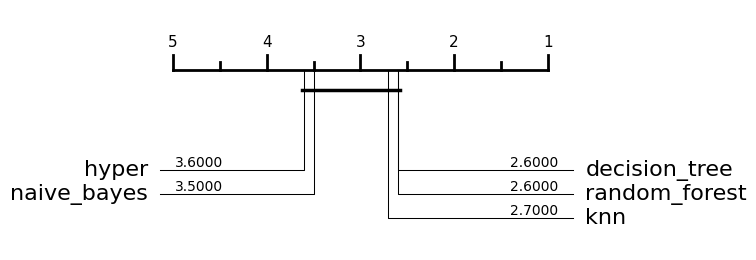

In [31]:
aeon.visualisation.plot_critical_difference(ranks_df.values,
                                            ranks_df.columns,
                                            test="Nemenyi")
plt.show()

## Task 4: Reflection
A short (less than 400 words) reflection on the results of the experiment and the experience of running it.


The goal of this assignment is to create and evaluate the performance of our ensemble KNN classifier (HyperParamEnsemble) against four traditional models: Decision Tree, Naive Bayes, KNN, and Random Forest.

I have used only light and numerical datasets already available in the Scikit-Learn library to reduce computational load on my budget PC.

From the results obtained after defining my HyperParamEnsembleClassifier as an ensemble of KNNs (with n_estimators set to 3), where each KNN was initialized with a random combination of parameters from the following grid:

param_grid = {
    'n_neighbors': list(range(3, 6, 2)),  
    'weights': ['distance'],  
    'metric': ['euclidean', 'manhattan']  
}
We can clearly see that our ensemble was the best-performing model compared to the other classifiers, achieving an accuracy of around 0.65 for large datasets and 1.00 for smaller datasets.

It’s important to note that the other models also used the best possible hyperparameters. Although a full grid search was not performed for all models (to alleviate computational load), the chosen hyperparameters were based on previous assignments (Task 2) and are expected to be the optimal settings for each model. Even with optimized parameters, none of the models were able to outperform our KNN ensemble.

The worst-performing model was Decision Tree, possibly because this model performs better with categorical data. However, Naive Bayes outperformed our HyperParamEnsemble on the Wine dataset. This suggests that certain models may be better suited for specific data structures. Additionally, Random Forest performed unexpectedly poorly on the Wine and Iris datasets, possibly due to limitations in feature selection or overfitting.

While the HyperParamEnsemble showed strong performance, this study was limited to only five datasets, meaning the results may not generalize to larger, more complex datasets. Future work could explore other ensembling techniques, such as stacking or boosting, and compare different base models beyond KNN.